In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy import constants as const

import scipy.integrate as integrate

import time

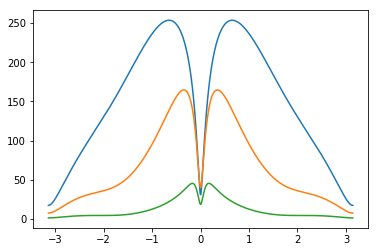

In [2]:
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.potential import plotRotcurve, vcirc
from galpy.actionAngle import actionAngleAdiabatic
from galpy.df import quasiisothermaldf
import numpy as np
from math import sqrt, sin, cos, tan, atan2, exp
from random import seed, random
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import interactive
from astropy import units as u
from astropy import constants as const
interactive(True)
 
PI = 3.141592
 
seed(datetime.now())
 
mp = MWPotential2014
R_0 = 8200.0
 
def random_direction():
    # returns a random 3D unit vector
    x1 = x2 = 1000.
    while (x1*x1 + x2*x2 >= 1):
        x1 = 2*random()-1
        x2 = 2*random()-1
    return np.array([2*x1*sqrt(1-x1*x1-x2*x2),2*x2*sqrt(1-x1*x1-x2*x2),1-2*(x1*x1+x2*x2)])
 
def v_orbit(r):
    return 220.0*vcirc(mp, r/R_0)
 
def v_disp_r(r):
    return 35.0*exp(-(r-R_0)/R_0)
 
def v_disp_z(r):
    return 20.0*exp(-(r-R_0)/R_0)
 
def sample(sigma):
    return np.random.normal(0.0, sigma)
 
r_sun = R_0
# velocity of the sun:
v_sun = np.array([0, v_orbit(r_sun), 0])
# position of the sun:
x_sun = np.array([r_sun,0,0])
 
def velocity(distance, theta_s, phi_s, theta_d, phi_d, disperse=True):
    # distance is distance of object from the sun
    # theta_s and phi_s are not quite galactic coordinates, theta_s=0 points OUT of the galaxy
    # theta_d and phi_d denote the direction of the normal vector of the plane of the dark disk
    # set disperse to True or False depending on whether you want to sample from the velocity distribution or just get the average
    # line of sight from the sun to the object:
    los = np.array([sin(theta_s)*cos(phi_s), sin(theta_s)*sin(phi_s), cos(theta_s)])
    # position of the object
    x = (-1)*x_sun + distance*los
    r = sqrt(np.dot(x,x))
    u = np.array([  distance*( cos(theta_s)*sin(theta_d)*sin(phi_d) - cos(theta_d)*sin(theta_s)*sin(phi_s) ),
                    -distance*cos(theta_s)*cos(phi_d)*sin(theta_d) + cos(theta_d)*( -r_sun + distance*cos(phi_s)*sin(theta_s) ),
                    sin(theta_d)*( (r_sun - distance*cos(phi_s)*sin(theta_s) )*sin(phi_d) + distance*cos(phi_d)*sin(theta_s)*sin(phi_s) ) ])
    velocity_direction = (-1)*u/(sqrt(np.dot(u,u)))
    if disperse:
        return sqrt(v_orbit(r)**2 + v_disp_z(r)**2 + v_disp_r(r)**2)*velocity_direction
    else:
        return v_orbit(r)*velocity_direction
 
def relative_velocity(d, p, b, l, theta_d, phi_d, velocity, disperse=True):
    # d is distance to the source
    # p is fractional distance of the lens
    # b, l is galactic latitude, longitude
    # psi_source, psi_lens are the angles the velocities of the source/lens make to the galactic plane
    # set disperse to True or False depending on whether you want to sample from the velocity distribution or just get the average
    # line of sight to the source:
    los = np.array([sin(PI/2-b)*cos(l), sin(PI/2-b)*sin(l), cos(PI/2-b)])
    # velocity of the source in sun's rest frame:
    #print(d)
    v_source = velocity(d,PI/2-b,l,theta_d,phi_d,disperse) - v_sun
    # velocity of the lens in sun's rest frame:
    v_lens = velocity(d*p,PI/2-b,l,theta_d,phi_d,disperse) - v_sun
    # component of source velocity perpendicular to line of sight:
    v_source_perp = v_source - np.dot(v_source,los)*los
    # component of lens velocity perpendicular to line of sight:
    v_lens_perp = v_lens - np.dot(v_lens,los)*los
    return np.linalg.norm(v_source_perp - v_lens_perp)
 
phis = np.linspace(-PI,PI,1000)
vs = [relative_velocity(0.8*R_0,0.01,0,phi,1,0,velocity,True) for phi in phis]
vs2 = [relative_velocity(0.8*R_0,0.49,0,phi,1,0,velocity,True) for phi in phis]
vs3 = [relative_velocity(0.8*R_0,0.9,0,phi,1,0,velocity,True) for phi in phis]
 
plt.plot(phis,vs)
plt.plot(phis,vs2)
plt.plot(phis,vs3)

In [3]:
#density functions
R0 = 8200.0*u.parsec #galactic radius of earth

def rho_baryon(r,z,th,q):
    A = 0.04*u.solMass/(u.parsec**3)
    hr = 3000.0*u.parsec
    R0 = 8200.0*u.parsec
    hz = 400.0*u.parsec
    return A*np.exp(-1*(r - R0)/hr)*np.exp(-1*np.abs(z)/hz)

def rho_mirrordisk(r,z,th,q): #dark version of the baryonic disk
    #use q as 2-element array to rescale z and r
    #figure out normalization so total DM stays the same
    #maybe make fiducial model have same mass as baryons, not CDM
    #so instead of f_DM, we would be constraining rho_mir/rho_bar
    A = 0.04*u.solMass/(u.parsec**3) /(q[0]**2*q[1])
    hr = 3000.0*u.parsec *q[0]
    R0 = 8200.0*u.parsec
    hz = 400.0*u.parsec*q[1]
    return A*np.exp(-1*(r - R0)/hr)*np.exp(-1*np.abs(z)/hz)
    
    
def rho_mirrordisk_tilt(r,z,th,q): #tilted by some angles, q = [theta of tilt, +phi]
    A = 0.04*u.solMass/(u.parsec**3)
    hr = 3000.0*u.parsec 
    R0 = 8200.0*u.parsec
    hz = 400.0*u.parsec
    
    theta = q[0]
    phi = q[1]
    x,y,z = r*np.cos(th), r*np.sin(th), z
    
    x,y,p = x*np.cos(theta) - y*np.sin(theta), y*np.cos(theta) + x*np.sin(theta), z #rotate theta around z axis
    
    x,y,z = x, y*np.cos(phi) - z*np.sin(phi), z*np.cos(phi) + y*np.sin(phi)
    
    x,y,p = x*np.cos(theta) + y*np.sin(theta), y*np.cos(theta) - x*np.sin(theta), z #rotate theta around z axis
    
    
    r = np.sqrt(x**2 + y**2)
    z = z
    return A*np.exp(-1*(r - R0)/hr)*np.exp(-1*np.abs(z)/hz)
    
def rho_semis(r, z,th,q): #standard semi-isothermal halo
    R = np.sqrt(r**2 + (z/q)**2)
    A = 0.01 *u.solMass / (u.parsec**3) #originally 0.0079
    R0 = 8200.0*u.parsec
    Rc = 5000.0*u.parsec
    #print(r,z,R)
    return A*(R0**2 + Rc**2)/(q*(R**2 + Rc**2))

def rho_NFW(r,z,th,q): #NFW halo distribution
    A = 0.014*u.solMass / (u.parsec**3)
    Rs = 16000*u.parsec
    
    R = np.sqrt(r**2 + (z/q)**2)
    
    x = R/Rs    
    return A/(x*(1 + x)**2)

def galcoord(d, l, b):
    R0 = 8200.0*u.parsec #galactic radius of earth
    z = d*np.sin(b)
    l = l*np.pi/180
    b = b*np.pi/180
    r = np.sqrt(R0**2 + (d*np.cos(b))**2 - 2.0*R0*d*np.cos(b)*np.cos(l))
    th = np.pi - l - np.arcsin(np.sin(l)*R0/r).value
    return r,z,th

def density(x,D,l,b,q,rhofunc):
    d = D*x
    r,z,th = galcoord(d,l,b)
    return rhofunc(r,z,th,q)

def logsense(m,m0,mr):
    return 1.0/(1.0 + (m/m0)**(-1.0/mr))


In [4]:
#v_c = 220*u.km/u.s #different? make this a function of position
v_is = 220*u.km/u.s
def v_c(L,x,b,l,iso):
    L = (L/u.pc).value
    #print(L,x,b,l)
    if iso:
        return 220*u.km/u.s
    else:
        return relative_velocity(L,x,b,l,0,0, velocity, True)*u.km/u.s

#R0 = 8200.0*u.parsec #galactic radius of earth

def rE(m, x, L):
    return np.sqrt(4*m*L*x*const.G*(1.0-x)/const.c**2).decompose()

def t_hat(m):
    return 130*np.sqrt(m/u.solMass)*u.day

def argument_starmass(m,L,t,l,b,q,rho_baryon):
    return m**-2.35*integrate.quad(dGdt_arg, 0.0, 1.0, args = (m,L,t,l,b,1.0,rho_baryon))[0]
 
def expfac(m,x,L,t,l,b,iso):
    arg = -4*rE(m,x,L)**2/(t**2*v_c(L,x,b,l,iso)**2).decompose() #velocity is called here
    return np.exp(arg)

def dGdt_arg(x,m,L,t,l,b,q,rhofunc,iso):
    tu = t*u.day
    m = m*u.solMass
    return (u.day**2*32.0*L*density(x,L,l,b,q,rhofunc)*rE(m,x,L)**4*expfac(m,x,L,tu,l,b,iso)/(tu**4*m*v_c(L,x,b,l,iso)**2)).decompose()

def dGdt(t,m,L,cutoff,l,b,q,rho_dm):
    output_DM = integrate.quad(dGdt_arg, 0.0, 1.0, args = (m,L,t,l,b,q,rho_dm))[0]
    
    lowm = np.maximum(0.01,0.01*(t/130)**2)
    highm = np.maximum(1,100*(t/130)**2)
    print('halfway there')
    #output_B = integrate.quad(argument_starmass, lowm, highm, args = (L,t,l,b,q,rho_baryon))[0]
    output_B = integrate.quad(dGdt_arg, 0.0, 1.0, args = (0.36,L,t,l,b,1.0,rho_baryon))[0]
    unc_B = np.sqrt(output_B)
    req_B = unc_B #np.maximum(1.0,unc_B)
    print(t, output_DM, output_B, unc_B, req_B)
    return output_DM*(np.greater(t,cutoff)*np.sqrt(1000.0 +  t))/req_B #used to have *(1000.0 +  t)

def N(m,L,cutoff,l,b,q, rho_dm, want_B, dm_iso = True, surtime = 4400, error = 0):
    L = L*1000*u.parsec #distance to the source, from kpc to pc
    llim = np.log10(np.maximum(cutoff,10*np.sqrt(m)))
    ulim = np.log10(np.maximum(cutoff*1000,10000*np.sqrt(m)))
    #print(llim, ulim)
    n = 30
    T = np.logspace(llim, ulim, n)
    N_B = np.logspace(llim, ulim, n)
    N_D = np.logspace(llim, ulim, n)
    rat = np.logspace(llim, ulim, n)
    step = T - np.roll(T,1)
    step[0] = 0
    i = 0
    for t in T:
        if want_B: N_B[i] = 17e9*integrate.quad(dGdt_arg, 0.0, 1.0, args = (0.36,L,t,l,b,q,rho_baryon, False))[0]*(t+surtime)*step[i] #use average sqrt(mass) insted of average mass
        N_D[i] = 17e9*integrate.quad(dGdt_arg, 0.0, 1.0, args = (m,L,t,l,b,q,rho_dm,dm_iso))[0]*(t+surtime)*step[i]
        if (N_B[i] < 1.0):
            N_B[i] = 1.0
        if (N_D[i] < 1.0):
            N_D[i] = 1.0
            
        
        if want_B: rat[i] =  N_D[i]/np.sqrt(N_B[i] + (error*N_B[i])**2) #add 5% inherrent uncertainty on baryon count, so sqrt(N_B + (0.05 N_B)^2)
        #print(t, N_B[i], N_D[i], rat[i])
        
        i = i+1
    if want_B: 
        chis = np.sqrt(np.sum(rat**2))
    else:
        chis = np.sqrt(np.sum(N_D**2))
    
    #plt.loglog(T, N_B, label = 'baryon')
    #plt.loglog(T,N_D, label = 'DM')
    #plt.loglog(T,np.sqrt(N_B), label = 'sqrt(B)')
    #plt.loglog(T,rat, label = 'ND/sqrt(NB)')
    #plt.loglog(T,step,label = 'stepsize')
    #plt.legend()
    
    return chis



Seperation between microlensing code, and the stuff I do with is

In [5]:
hdu = fits.open('galaxy1.fits')
data = hdu[1].data
data_masked = data[~np.less(np.sqrt(data['glat']**2 + ((data['glon']+180)%360 - 180)**2), 2.0)]
data_masked5 = data[~np.less(np.sqrt(data['glat']**2 + ((data['glon']+180)%360 - 180)**2), 5.0)]


In [6]:
def N_looped(m,cutoff,N_sources,q, rho_dm, baryons, iso = True, error = 0, data = data):
    #import LSST Sources from Galaxia
    N_step = N_sources - 1
    res = np.int(data.size/N_step)
    N_ev = 0
    i = 1
    for s in data[::res]:
        n = N(m,s['rad'], cutoff, s['glon'], s['glat'],q, rho_dm, baryons, dm_iso = iso, error = error)
        N_ev = N_ev + n**2
        #print(n**2, N_ev)
        n_sofar = np.sqrt(N_ev/i)
        i = i+1
        #print('done for another source')
        print('done for another source.', n, n_sofar)
        
    N_ev = np.sqrt(N_ev/N_sources)
    return N_ev

In [7]:
from scipy.stats import norm
from scipy.stats import poisson
from scipy.special import logsumexp

def gen_events(m, N_sources, q, rho_dm, iso=True, data = data, surtime = 4400):
    cutoff = 1.0
    
    N_step = N_sources - 1
    res = np.int(data.size/N_step)
    N_ev = 0
    #i = 1
    
    sources_per_LoS = 17e9/N_sources
    
    llim = np.log10(np.maximum(cutoff,np.sqrt(m)))
    ulim = np.log10(np.maximum(cutoff*100,10000*np.sqrt(m)))
    #print(llim, ulim)
    n = 20
    T = np.logspace(llim, ulim, n)
    N_B = np.zeros((N_sources, n))
    N_D = np.zeros((N_sources, n))
    N_T = np.zeros((N_sources, n))
    
    rat = np.logspace(llim, ulim, n)
    step = T - np.roll(T,1)
    step[0] = 0
    
    i_s = 0
    
    for s in data[::res]:
        
        L = s['rad']*1000*u.parsec
        l = s['glon']
        b = s['glat']
        
        i_t = 0
        for t in T:
            
            N_B[i_s, i_t] = sources_per_LoS*integrate.quad(dGdt_arg, 0.0, 1.0, args = (0.36,L,t,l,b,q,rho_baryon, False))[0]*(t+surtime)*step[i_t] #use average sqrt(mass) insted of average mass
            N_D[i_s, i_t] = sources_per_LoS*integrate.quad(dGdt_arg, 0.0, 1.0, args = (m,L,t,l,b,q,rho_dm, iso))[0]*(t+surtime)*step[i_t]
            
            #if (N_B[i_s, i_t] < 1.0):
            #    N_B[i_s, i_t] = 1.0
            #if (N_D[i_s, i_t] < 1.0):
            #    N_D[i_s, i_t] = 1.0
            
            #p = poisson.pmf(np.rint(N_B[i_s, i_t]), (f_DM*N_D[i_s, i_t] + N_B[i_s, i_t]))
            #if (p==0):
            #    printf('failed')
            #    printf('baryon event number: ', N_B[i_s, i_t])
            #    printf('dark event number: ', N_D[i_s, i_t])


            #if want_B: rat[i] =  N_D[i]/np.sqrt(N_B[i] + (error*N_B[i])**2) #add 5% inherrent uncertainty on baryon count, so sqrt(N_B + (0.05 N_B)^2)
            #print(t, N_B[i], N_D[i], rat[i])

            i_t = i_t+1
        

        i_s = i_s + 1
        #n = N(m,s['rad'], cutoff, s['glon'], s['glat'],q, rho_dm, baryons, dm_iso = iso, error = error)
        #N_ev = N_ev + n**2
        #print(n**2, N_ev)
        #n_sofar = np.sqrt(N_ev/i)
        #i = i+1
        #print('done for another source')
        #print('done for another source.', n, n_sofar)
        
        
    #print(N_D)
    #print(N_B)
    
    return (N_B, N_D), T

def new_prob(events, f_DM, error = 0.05):
    
    N_B = events[0]
    N_D = events[1]
    
    step = error/5
    Ab = np.arange(1 - 4*error, 1 + 4*error, step)
    def p_alpha(a):
        return norm.pdf(a, loc = 1, scale = error)

    Ptot = 0
    i = 0
    sum_log = np.zeros_like(Ab)
    for ab in Ab:
        Lpois = poisson.logpmf(np.rint(N_B), (f_DM*N_D + ab*N_B))
        #print(np.any(pois==0))
        #print(np.sum(Lpois))
        #print(pois)
        #print(pois)
        #print(np.sum(np.log(pois)))
        sum_log[i] = np.sum(Lpois)
        i = i+1
        #prod = np.prod(pois)
        #print('%f.d10'%prod)
        #Ptot = Ptot + prod*p_alpha(ab)*step
        
    logP = logsumexp(sum_log, b=p_alpha(Ab)*step)
    #print(logP)
    return logP



In [8]:
#no longer works, functions changes, need to update for testing
#new_prob(1.0, 1e-4, 5, 1.0, rho_NFW, error = 0.05)

In [63]:
F = np.logspace(-6,-2, 50)
p50 = np.zeros_like(F)

i = 0
events = gen_events(1.0, 50, 1.0, rho_NFW)

print('done generating events')

for f in F:
    p50[i] = new_prob(events, f, error = 0.05)
    print(f, p50[i])
    i = i+1
    
new_p50 = np.exp(p50 - np.mean(p50))

KeyboardInterrupt: 

In [8]:
#master function that should give max f

def max_f(m, N_sources, q, rho_DM, err_baryons = 0.05, logfexp = -4, req_prob = 0.95, data = data, surtime = 4400):
    events, T = gen_events(m, N_sources, q, rho_DM, data = data, surtime = surtime)
    
    print('done generating events')
    
    plogf_array = np.array([])
    logf_array = np.array([])
    
    if (logfexp == 0): #try to dynamically guess the best logfexp
        logfexp = 0
        plogf_m1 = -float('Inf')
        while True:
            f = np.power(10,logfexp)
            P = new_prob(events, f, error = err_baryons)
            plogf = np.log(f) + P #switch to log probability
            #print(logfexp, P, plogf)
            plogf_array = np.append(plogf_array, plogf)
            logf_array = np.append(logf_array, logfexp)
            
            if (plogf < plogf_m1):
                break
                
            if (logfexp < -1000):
                print('failed to find proper spot')
                break
                
            logfexp = logfexp - 0.1
            plogf_m1 = plogf
        
    F = np.logspace(logfexp - 6, logfexp + 6, 120)
    logP = np.zeros_like(F)
    
    #plt.plot(logf_array, plogf_array)
    #plt.show()
    
    #print('events')
    #print(events)
    
    #nplot = 10
    #for i in np.arange(nplot):
    #    plt.plot(T, events[0][i,:], c = [i/nplot, 1 - i/nplot, 0], ls = '-')
    #    plt.plot(T, events[1][i,:], c = [i/nplot, 1 - i/nplot, 0], ls = '--')
    #plt.yscale('log')
    #plt.xscale('log')
    #plt.ylim(1e-2, 1e15)
    #plt.show()
    
    
    i=0
    for f in F:
        lP = new_prob(events, f, error = err_baryons)
        #print(f, lP)
        if(np.isinf(lP)):
            break
        
        logP[i] = lP
        i = i+1
     
    #print('logP: ', logP)
    logP = logP[:i]
    F = F[:i]
    
    #plt.plot(F, F*np.exp(logP))
    #plt.xscale('log')
    #plt.show()
    
    #print(logP)
    #print(logP - np.max(logP))
    
    logP = np.array(logP, dtype = np.float128)
    
    P = np.exp(logP - np.max(logP))
    
    
    Plog = F*P
    
    logF = np.log10(F)
    dif = logF - np.roll(logF, 1)
    dif[0] = dif[1]
    
    normp = np.sum(Plog*dif)
    
    pLnorm = Plog/normp
    
    plt.plot(logF, pLnorm)
    
    
    cs = np.cumsum(pLnorm*dif)
    
    plt.plot(logF, cs)
    plt.show()
    #print(cs[-1])
    #print(cs)
    
    #guess = np.mean(logF)
    #i=0
    #for s in cs:
    #    if(s>req_prob):
    #        guess = logF[i]
    #        break
    #    i = i+1
    
    cs = np.float64(cs)
    fcut = np.interp(req_prob, cs, logF)
    return fcut
    
qmd = np.array([0.1,0.1])
#max_f(1, 50, qmd, rho_mirrordisk, logfexp = 0, data = data_masked)

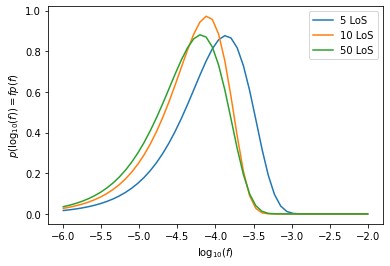

In [88]:
plog5 = F*p5c
logF = np.log10(F)

dif = logF - np.roll(logF, 1)
dif[0] = dif[1]
normp = np.sum(plog5*dif) #calculate the normalization factor over f
pLnorm5 = plog5/normp

plt.plot(logF, pLnorm5, label = '5 LoS')



plog10 = F*p10
normp10 = np.sum(plog10*dif)

p10norm = plog10/normp10

plt.plot(logF, p10norm, label = '10 LoS')


plog50 = F*new_p50
normp50 = np.sum(plog50*dif)

p50norm = plog50/normp50

plt.plot(logF, p50norm, label = '50 LoS')

#plt.xscale('log')
#plt.yscale('log')

#plt.ylim(1e-10,10)

plt.ylabel('$p(\log_{10}(f)) = f p(f)$')
plt.xlabel('$\log_{10}(f)$')
plt.legend()

plt.savefig('smooth_prob_logf.svg')

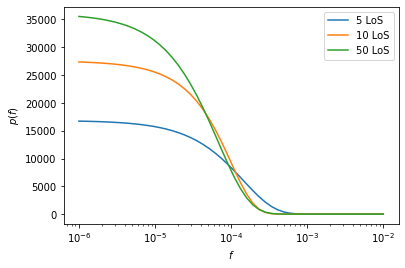

In [89]:
plt.plot(F, pLnorm5/F, label = '5 LoS')
plt.plot(F, p10norm/F, label = '10 LoS')
plt.plot(F, p50norm/F, label = '50 LoS')
plt.xscale('log')
#plt.yscale('log')

plt.ylabel('$p(f)$')
plt.xlabel('$f$')
plt.legend()
#plt.yscale('log')
#plt.ylim(1e-4, 2e4)

plt.savefig('smooth_prob_f.svg')

# Actual code that runs things

0.0001 -28.0 1e-28
/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: IntegrationWarning: The integral is probably divergent, or slowly convergent.



KeyboardInterrupt: 

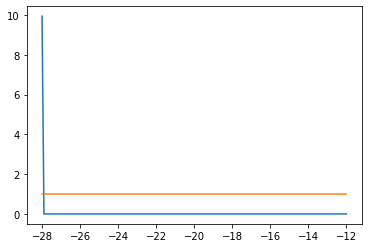

In [52]:
M = np.logspace(-4, 7, num = 20)
fmd = np.zeros_like(M)
lfmd = np.zeros_like(M)

i = 0
for m in M:
    lfmd[i] = max_f(m, 20, np.array([0.01,0.01]), rho_mirrordisk, logfexp = -20) #use the new function
    fmd[i] = np.power(10, lfmd[i])
    print(m, lfmd[i], fmd[i])
    i = i+1
    
plt.loglog(M,fmd/logsense(M,1e-2,0.5))

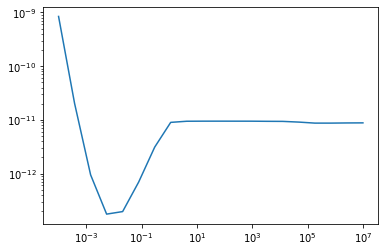

In [48]:
plt.loglog(M,fmd/logsense(M,1e-2,0.5))

[9.99900010e-05 1.43638372e-03 2.02719267e-02 2.29367358e-01
 8.10653842e-01 9.84021685e-01 9.98872435e-01 9.99921530e-01
 9.99994544e-01 9.99999621e-01 9.99999974e-01 9.99999998e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00]


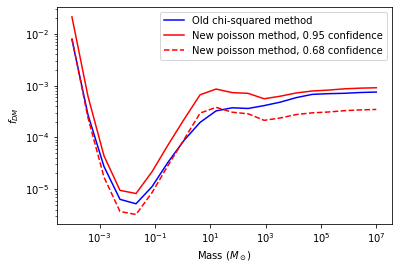

In [32]:
print(logsense(M,1e-2,0.5))


con_plot('n_20_bar_array.txt', 'b-', 'Old chi-squared method')

plt.loglog(M, f/logsense(M,1e-2,0.5), 'r-', label = 'New poisson method, 0.95 confidence')
plt.loglog(M, f1/logsense(M,1e-2,0.5), 'r--', label = 'New poisson method, 0.68 confidence')

plt.legend()

plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('$f_{DM}$')
plt.savefig('newmethod_test.png')

In [ ]:
M = np.logspace(-4, 7, num = 20)

m_array = np.array([])
n_20_bar_array = np.array([])
#n_20_bar_001_array = np.array([])
#n_20_bar_005_array = np.array([])

cutoff = 1
nstars = 1.0e9

for m in M:
    start = time.time()
    #n_20_bar = N_looped(m,cutoff,20,1.0, rho_NFW, True, error = 0.0)
    n_20_bar_001 = N_looped(m,cutoff,20,1.0, rho_NFW, True, error = 0.01)
    n_20_bar_005 = N_looped(m,cutoff,20,1.0, rho_NFW, True, error = 0.05)
    
     
    m_array = np.append(m_array, m)
    #n_20_bar_array = np.append(n_20_bar_array, n_20_bar)
    n_20_bar_001_array = np.append(n_20_bar_001_array, n_20_bar_001)
    n_20_bar_005_array = np.append(n_20_bar_005_array, n_20_bar_005)
    
    end = time.time()
    tim = end - start
    print(m,n_20_bar_001, n_20_bar_005,tim)

np.savetxt('m_array.txt', m_array)
#np.savetxt('n_20_bar_array_dispersion.txt', n_20_bar_array)
np.savetxt('n_20_bar_001_array_dispersion.txt', n_20_bar_array_001)
np.savetxt('n_20_bar_005_array_dispersion.txt', n_20_bar_array_005)


done for another source. 858.1955049919582 858.1955049919582
done for another source. 15934.51468636534 11283.732933182644
done for another source. 105125.38987896139 61389.44766819571
done for another source. 87874.09818272134 68970.73652362458
done for another source. 2313741.352301349 1036573.8657071883
done for another source. 301319.03876966366 954220.4548269401
done for another source. 2051010.1689960563 1175333.5558036296
done for another source. 386189.19611954095 1107869.8517304212
done for another source. 2140474.676262342 1264939.0282497967
done for another source. 819782.8219916854 1227708.458142181
done for another source. 1576907.6783663137 1263448.3263898036
done for another source. 223298.79351664247 1211375.9655592456
done for another source. 493569.88851709093 1171875.2885231534
done for another source. 554649.3612327933 1138935.214135863
done for another source. 566964.6890010573 1110011.317256298
done for another source. 677149.8315392011 1088014.4978615143
done for

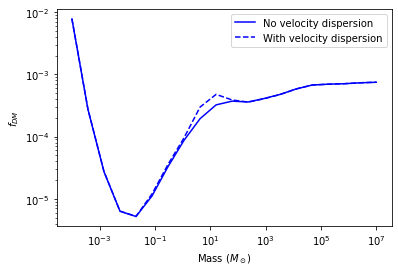

In [21]:
def con_plot(name, style, label):
    m = np.loadtxt('m_array.txt')
    f = 1/np.loadtxt(name)
    m = m[~np.isnan(f)]
    f = f[~np.isnan(f)]
    #print(m,f)
    plt.loglog(m,f/logsense(m,1e-2,0.5), style, label = label)
    

con_plot('n_20_bar_array.txt', 'b-', 'No velocity dispersion')
con_plot('n_20_bar_array_dispersion.txt', 'b--', 'With velocity dispersion')
plt.legend()
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('$f_{DM}$')
plt.savefig('newfig_veldisp.pdf')
plt.show() 


In [ ]:
M = np.logspace(-4, 7, num = 30)

done generating events


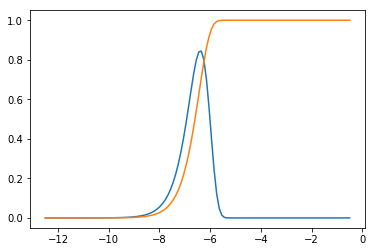

done generating events


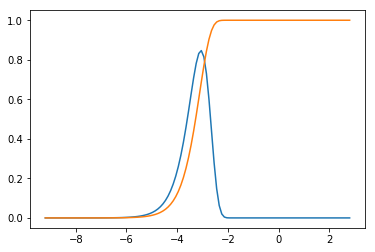

done generating events


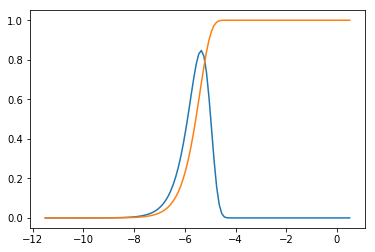

done the others
done generating events


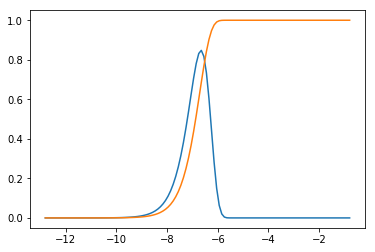

done generating events


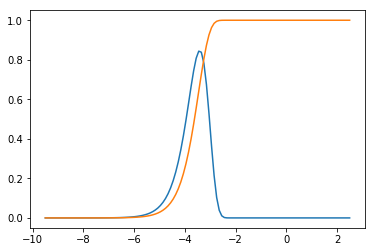

done generating events


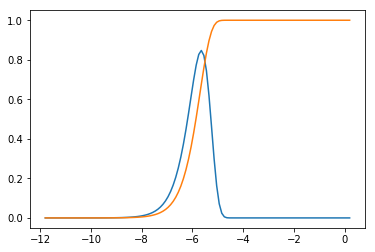

done the others
done generating events


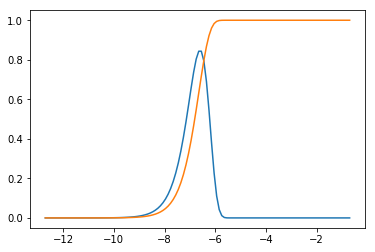

done generating events


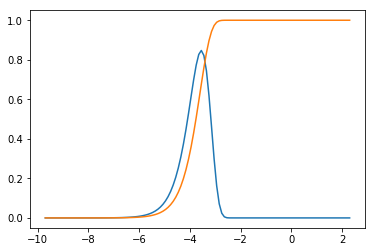

done generating events


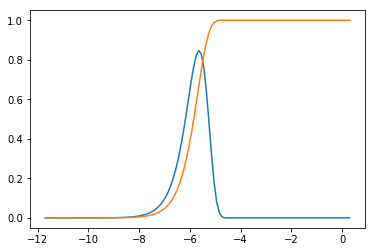

done the others
done generating events


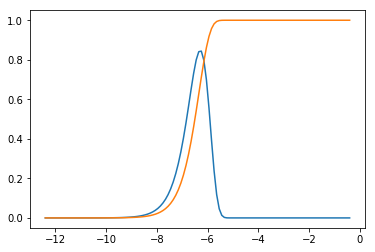

done generating events


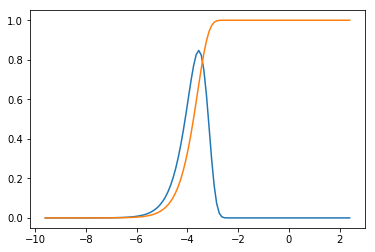

done generating events


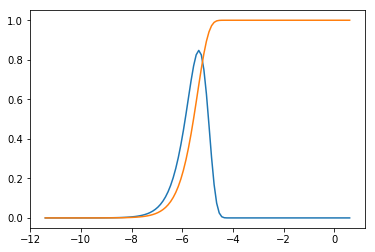

done the others
done generating events


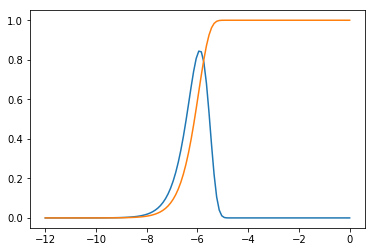

done generating events


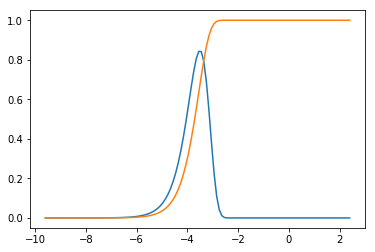

done generating events


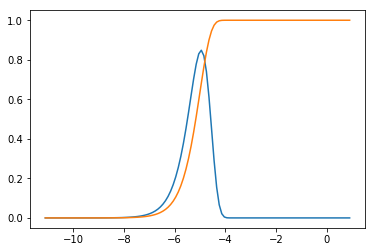

done the others
done generating events


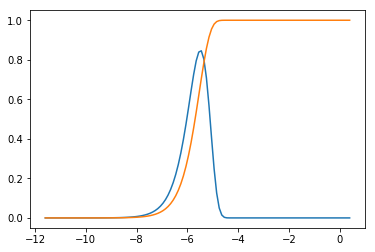

done generating events


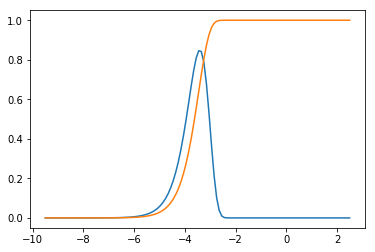

done generating events


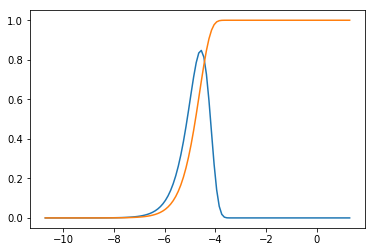

done the others
done generating events


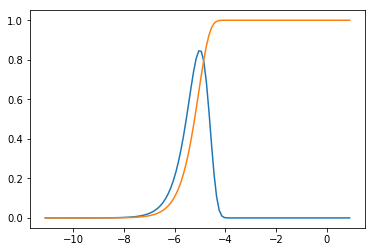

done generating events


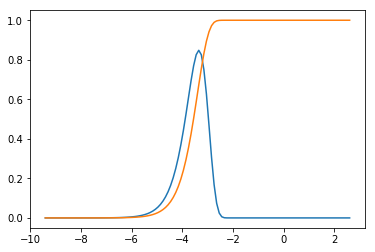

done generating events


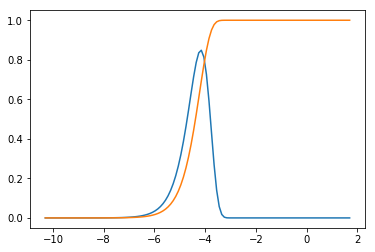

done the others
done generating events


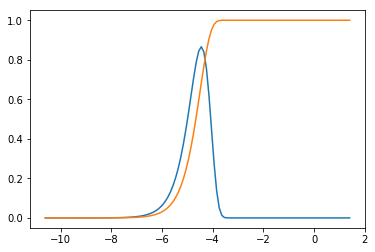

done generating events


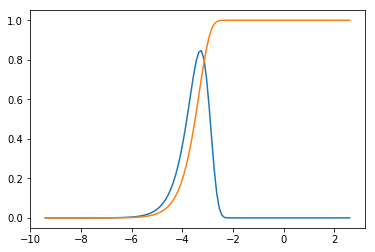

done generating events


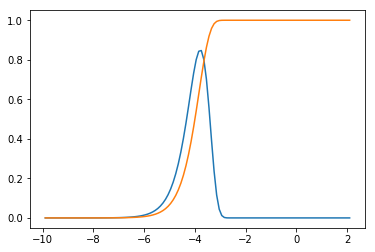

done the others
done generating events


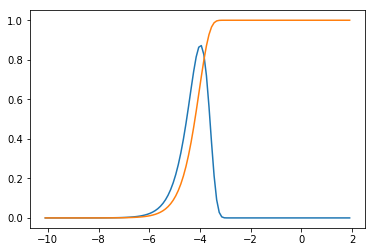

done generating events


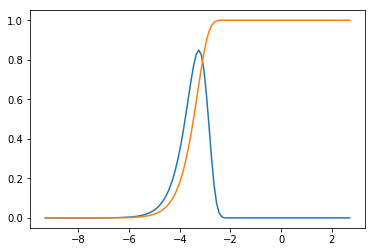

done generating events


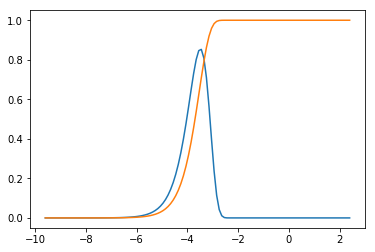

done the others
done generating events


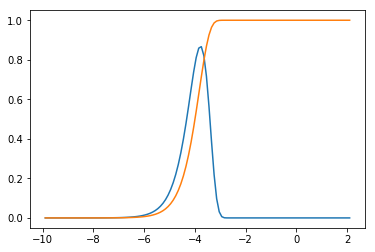

done generating events


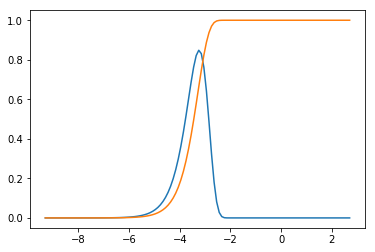

done generating events


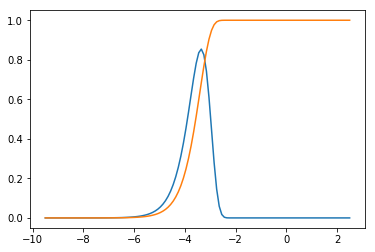

done the others
done generating events


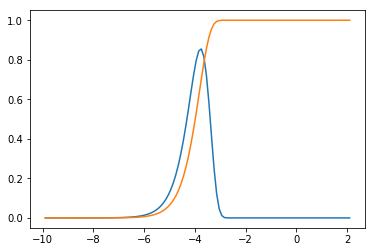

done generating events


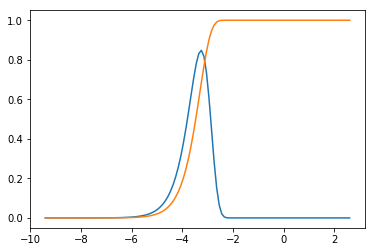

done generating events


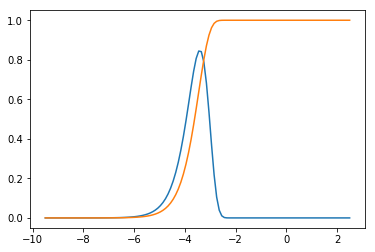

done the others
done generating events


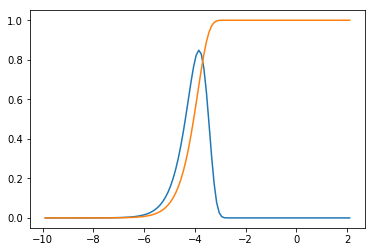

done generating events


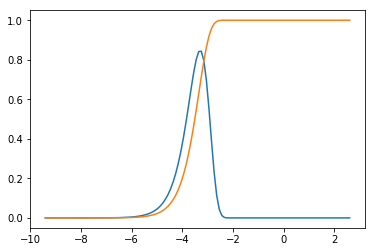

In [ ]:
#constraints with different assumptions

M = np.logspace(-4, 7, num = 20)

m_array = np.array([])
n_20_bar_array = np.array([])
n_20_nobar_array = np.array([])
core_bar_array = np.array([])
core_nobar_array = np.array([])

core_nobar_notime_array = np.array([])
core_nobar_1yr_array = np.array([])

cutoff = 1
nstars = 1.0e9

for m in M:
    start = time.time()
    #n_20_bar = N_looped(m,cutoff,20,1.0, rho_NFW, True)
    #print('n_20_bar, ', n_20_bar)
    #n_20_nobar = N_looped(m,cutoff,20,1.0, rho_NFW, False)
    #print('n_20_nobar, ', n_20_nobar)
    #core_bar = N(m,8.3,cutoff,0,0,1.0, rho_NFW, True)
    #core_nobar = N(m,8.3,cutoff,0,0,1.0, rho_NFW, False)
    
    #core_nobar_notime = N(m,8.3,cutoff,0,0,1.0, rho_NFW, False, surtime = 0)
    #core_nobar_1yr = N(m,8.3,cutoff,0,0,1.0, rho_NFW, False, surtime = 365)
    
    core_nobar = max_f(m, 100, 1.0, rho_NFW, logfexp = 0, data = data, surtime = 4400)
    core_nobar_notime = max_f(m, 100, 1.0, rho_NFW, logfexp = 0, data = data, surtime = 0)
    core_nobar_1yr = max_f(m, 100, 1.0, rho_NFW, logfexp = 0, data = data, surtime = 365)
    print('done the others')
    
    #plt.scatter(m,n, c = 'g')
    #result_array_20los = np.append(result_array_20los, result)
    
    m_array = np.append(m_array, m)
    #n_20_bar_array = np.append(n_20_bar_array, n_20_bar)
    #n_20_nobar_array = np.append(n_20_nobar_array, n_20_nobar)
    #core_bar_array = np.append(core_bar_array, core_bar)
    core_nobar_array = np.append(core_nobar_array, core_nobar)

    core_nobar_notime_array = np.append(core_nobar_notime_array, core_nobar_notime)
    core_nobar_1yr_array = np.append(core_nobar_1yr_array, core_nobar_1yr)

    end = time.time()
    tim = end - start
    #print(m,n_20_bar,tim)

#np.savetxt('m_array.txt', m_array)
#np.savetxt('n_20_bar_array.txt', n_20_bar_array)
#np.savetxt('n_20_nobar_array.txt', n_20_nobar_array)
#np.savetxt('core_bar_array.txt', core_bar_array)
np.savetxt('time_fulltime.txt', core_nobar_array)
np.savetxt('time_notime.txt', core_nobar_notime_array)
np.savetxt('time_1yr.txt', core_nobar_1yr_array)


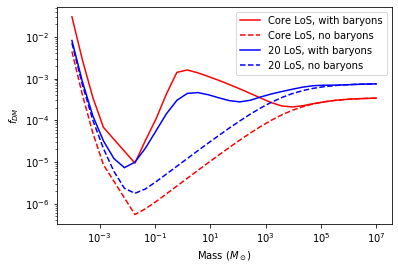

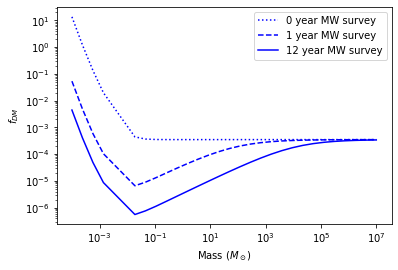

In [24]:
def con_plot(name, style, label):
    m = np.loadtxt('m_array.txt')
    f = 1/np.loadtxt(name)
    m = m[~np.isnan(f)]
    f = f[~np.isnan(f)]
    #print(m,f)
    plt.loglog(m,f/logsense(m,1e-2,0.5), style, label = label)
    

con_plot('core_bar_array.txt', 'r-', 'Core LoS, with baryons')
con_plot('core_nobar_array.txt', 'r--', 'Core LoS, no baryons')
con_plot('n_20_bar_array.txt', 'b-', '20 LoS, with baryons')
con_plot('n_20_nobar_array.txt', 'b--', '20 LoS, no baryons')
plt.legend()
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('$f_{DM}$')
plt.savefig('newfig_los_baryons.pdf')
plt.show() 

con_plot('core_nobar_notime_array.txt', 'b:', '0 year MW survey')
con_plot('core_nobar_1yr_array.txt', 'b--', '1 year MW survey')
con_plot('core_nobar_array.txt', 'b-', '12 year MW survey')
plt.legend()
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('$f_{DM}$')
plt.savefig('newfig_survey_time.pdf')
plt.show()


In [17]:
#constraints on tilted dark disk

Phis = np.linspace(np.pi/16, np.pi/4, 4)
Thetas = np.arange(0,2*np.pi, np.pi/2)

result_array_tilt = np.zeros([4,4])

j = 0
for theta in Thetas:
    i = 0
    for phi in Phis:
        q = [theta,phi]
        n_50 = N_looped(1.0,1.0,50, q, rho_mirrordisk_tilt)
        result_array_tilt[i,j] = n_50
        print('finished for ', theta, phi, n_50)
        i = i+1
    j = j+1
        
np.savetxt('result_array_tiltdisk_50.txt', result_array_tilt)

done for another source. 166.10758691202793 166.10758691202793
done for another source. 11.08037324024074 117.71683206083988
done for another source. 124.78452411184045 120.11894460450226
done for another source. 94.0144276636277 114.15383827057452
done for another source. 641.7214997410944 304.60823311183736
done for another source. 12.92371320856677 278.1180507028968
done for another source. 286.28009835571066 279.2986613121286
done for another source. 111.7396358409293 264.2299996435618
done for another source. 91.06266738271583 250.96089803525362
done for another source. 77.67081311398914 239.34600608611308
done for another source. 5.635250910355858 228.2137877968733
done for another source. 32.36039305389032 218.69767133822774
done for another source. 554.7312660697921 260.42433345785076
done for another source. 784.4359433213957 327.000500667494
done for another source. 25.47469932656661 315.98096402798944
done for another source. 69.8541228981258 306.44525845845715
done for anot

In [8]:
rat0 = N_looped(1.0,1.0,50, [0,0], rho_mirrordisk_tilt)

done for another source. 134.23656385238434 134.23656385238434
done for another source. 105.98907318577876 120.94035453411658
done for another source. 450.65616677066345 278.29487919477526
done for another source. 160.42734071677936 254.00839110527494
done for another source. 629.4645968206041 361.7476274028862
done for another source. 157.83884349186 336.45698837863733
done for another source. 442.1491982856621 353.49595748700654
done for another source. 292.60474833731547 346.4702877713925
done for another source. 107.46446392440146 328.61356796795894
done for another source. 181.24792466084767 316.97518888196214
done for another source. 124.19757391947307 304.53507650411495
done for another source. 115.91781048692111 293.48405405619576
done for another source. 109.34614447979897 283.596579551864
done for another source. 109.94168048917119 274.855602641057
done for another source. 232.2614915547132 272.2234171538421
done for another source. 92.47345703731915 264.5910964299623
done fo

[[-2.50462179 -2.50462179 -2.50462179 -2.50462179]
 [-2.59664749 -2.77525561 -2.65460199 -2.81904105]
 [-2.75390595 -2.9251239  -2.81561843 -2.97964553]
 [-2.82639193 -2.98338694 -2.94413963 -3.01452471]
 [-2.92153722 -2.99206394 -3.09216859 -3.02324666]]


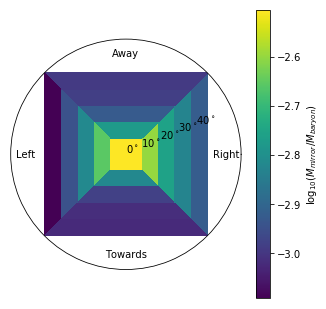

In [25]:
result_array_tilt = np.loadtxt('result_array_tiltdisk_50.txt')

r = np.linspace(0,5,6)
t = np.linspace(-1/4, 7/4, 5)*np.pi
rat = np.append(rat0*np.ones([1,4]), result_array_tilt, axis = 0)

con = np.log10(1/rat)

print(con)


fg = plt.figure(figsize=(5,5))
ax = fg.add_axes([0.1,0.1,0.8,0.8], projection='polar')
plt.yticks([0, 0.7, 1.6, 2.45, 3.3], ['$0^\circ$', '$10^\circ$', '$20^\circ$', '$30^\circ$', '$40^\circ$'])
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2], ['Right', 'Away', 'Left', 'Towards'])

ax.tick_params(axis = 'x', pad = -25)

im = ax.pcolormesh(t,r,con)
c = fg.colorbar(im, ax = ax)
c.set_label('$\log_{10}(M_{mirror}/M_{baryon})$')

rat

plt.savefig('tiltdisk.png')

[-2.50462179 -2.59664749 -2.75390595 -2.82639193 -2.92153722]


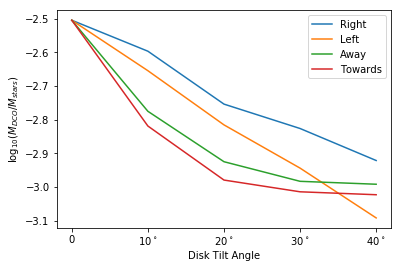

In [26]:
phi = np.linspace(0, np.pi/4, 5)

rat = np.append(rat0*np.ones([1,4]), result_array_tilt, axis = 0)

con = np.log10(1/rat)

print(con[:,0])

plt.plot(phi, con[:,0], label = 'Right')
plt.plot(phi, con[:,2], label = 'Left')

plt.plot(phi, con[:,1], label = 'Away')
plt.plot(phi, con[:,3], label = 'Towards')

plt.xticks(phi, ['0', '$10^\circ$', '$20^\circ$', '$30^\circ$', '$40^\circ$',])
plt.xlabel('Disk Tilt Angle')
plt.ylabel('$\log_{10}(M_{DCO}/M_{stars})$')
plt.legend()

plt.savefig('tiltdisk_lines.png')

In [ ]:
#rescale both dimensions of dark disk, and calculate mass-dependant constraints

Q = np.logspace(-1, 1, num=5)

#fexp = np.linspace(-8, -4, num=5)

M = np.logspace(-4, 7, num = 30)

f = np.zeros([5,30])

i = 0
j = 0

for q in Q:
    qa = np.array([q,q])
    print('new scale ', i, q)
    j = 0
    for m in M:
        logf = max_f(m, 100, qa, rho_mirrordisk, logfexp = 0) #use the new function
        print('logf: ', logf)
        f[i, j] = np.power(10, logf)
        print(j, m, f[i,j])
        j = j+1
    i = i+1
    
np.savetxt('rescaled_masscon_MD.txt', f)

(1e-08, 1)

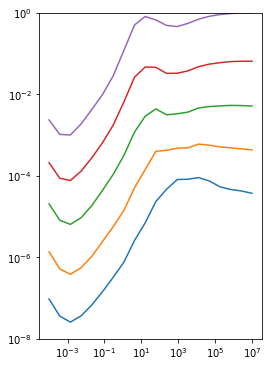

In [11]:
plt.figure(figsize = [4,6])


for i in np.arange(5):
    plt.plot(M, f[i,:])
plt.yscale('log')
plt.xscale('log')
plt.ylim((1e-8, 1))

new scale  0 0.01
/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: IntegrationWarning: The integral is probably divergent, or slowly convergent.

done generating events


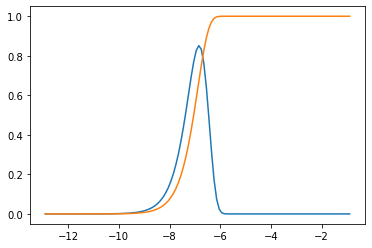

logf:  -6.416075271539154
0 5 3.8364074745148177e-07
new scale  1 0.039810717055349734
done generating events


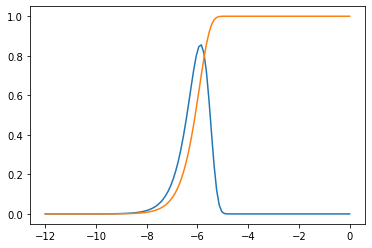

logf:  -5.4632003605989015
1 5 3.4419110248311487e-06
new scale  2 0.15848931924611134
done generating events


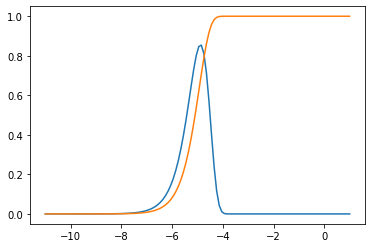

logf:  -4.4662833736418355
2 5 3.4175637647179636e-05
new scale  3 0.630957344480193
done generating events


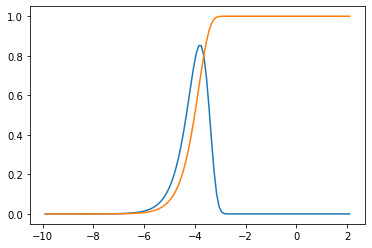

logf:  -3.3829313334996938
3 5 0.0004140651376737978
new scale  4 2.5118864315095797
done generating events


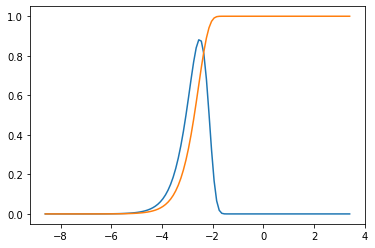

logf:  -2.1201870993138963
4 5 0.007582508410233673
new scale  5 10.0
done generating events


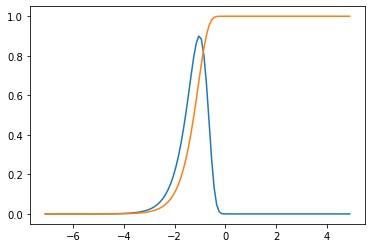

logf:  -0.6503484755837693
5 5 0.22369255211200534
new scale  0 0.01
/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: IntegrationWarning: The integral is probably divergent, or slowly convergent.

done generating events


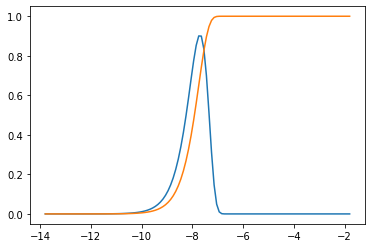

logf:  -7.3387445484578055
0 10 4.5841144454335595e-08
new scale  1 0.039810717055349734
done generating events


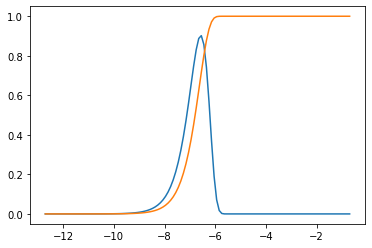

logf:  -6.20416865249083
1 10 6.249299624017977e-07
new scale  2 0.15848931924611134
done generating events


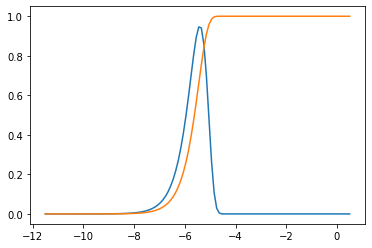

logf:  -5.064527253717266
2 10 8.61931487357318e-06
new scale  3 0.630957344480193
done generating events


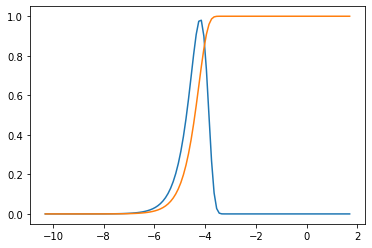

logf:  -3.8644144967714453
3 10 0.00013664240686757064
new scale  4 2.5118864315095797
done generating events


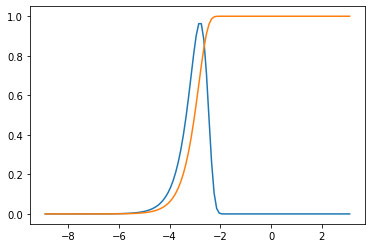

logf:  -2.465686368616728
4 10 0.0034222649659192113
new scale  5 10.0
done generating events


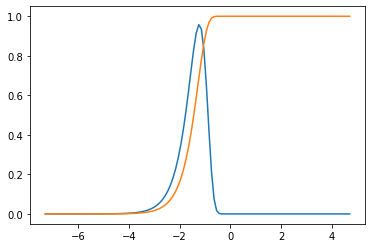

logf:  -0.8922565925932137
5 10 0.12815731718191506
new scale  0 0.01
/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: IntegrationWarning: The integral is probably divergent, or slowly convergent.

done generating events


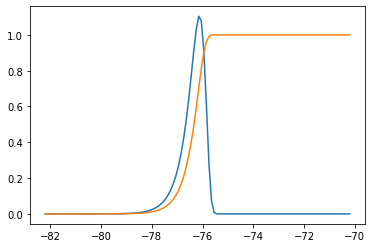

logf:  -75.86973761863129
0 20 1.3497781120775677e-76
new scale  1 0.039810717055349734
done generating events


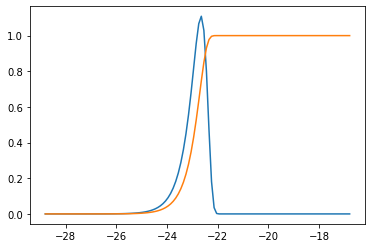

logf:  -22.405497729795208
1 20 3.930992997656773e-23
new scale  2 0.15848931924611134
/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: IntegrationWarning: The integral is probably divergent, or slowly convergent.

done generating events


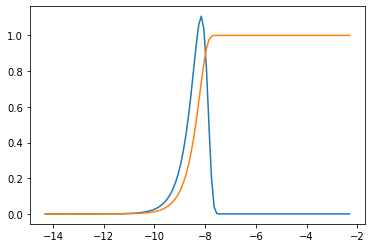

logf:  -7.898271282613232
2 20 1.2639465749579025e-08
new scale  3 0.630957344480193
done generating events


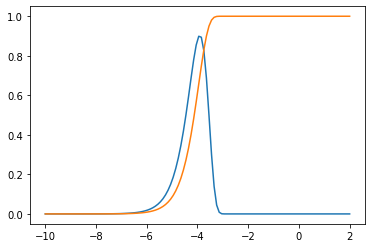

logf:  -3.5467356921224624
3 20 0.0002839646687161715
new scale  4 2.5118864315095797
done generating events


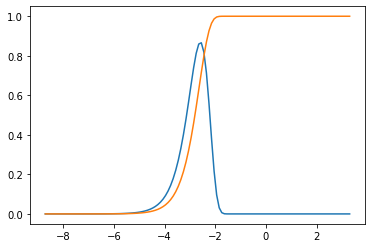

logf:  -2.1839054935827216
4 20 0.006547786443355914
new scale  5 10.0
done generating events


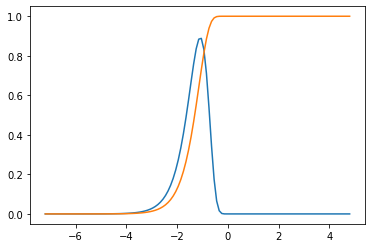

logf:  -0.7148847722609211
5 20 0.19280363951787918
new scale  0 0.01
/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: IntegrationWarning: The integral is probably divergent, or slowly convergent.

done generating events


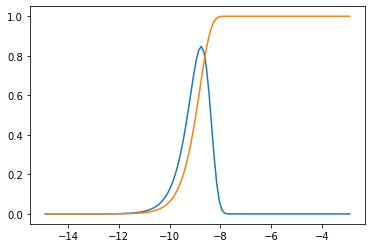

logf:  -8.329002576201368
0 30 4.688106011886913e-09
new scale  1 0.039810717055349734
done generating events


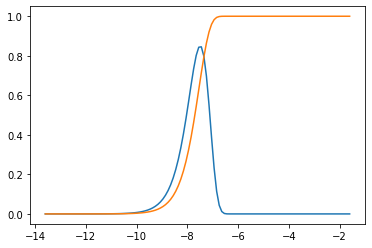

logf:  -7.069001839153854
1 30 8.530965013098397e-08
new scale  2 0.15848931924611134
done generating events


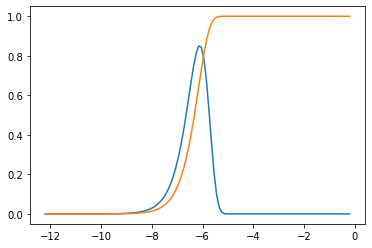

logf:  -5.687939139729613
2 30 2.0514496405302558e-06
new scale  3 0.630957344480193
done generating events


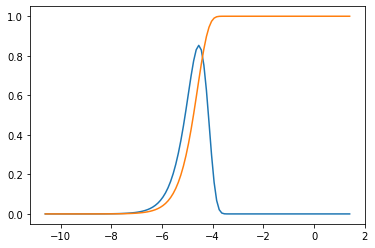

logf:  -4.126876068171203
3 30 7.466617980966372e-05
new scale  4 2.5118864315095797
done generating events


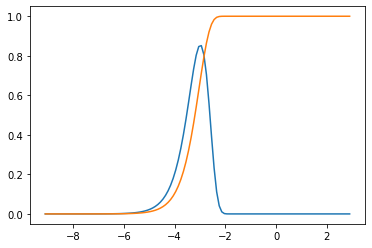

logf:  -2.5706599859498818
4 30 0.002687447655330182
new scale  5 10.0
done generating events


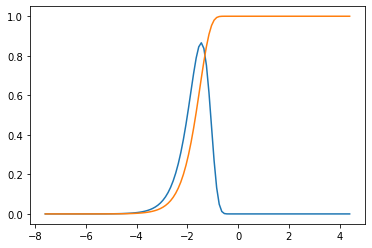

logf:  -1.0523724310871019
5 30 0.08863955537260168
new scale  0 0.01
/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: IntegrationWarning: The integral is probably divergent, or slowly convergent.

done generating events


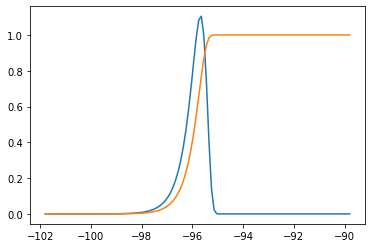

logf:  -95.42991868347912
0 50 3.716048012010504e-96
new scale  1 0.039810717055349734
/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: IntegrationWarning: The integral is probably divergent, or slowly convergent.

done generating events


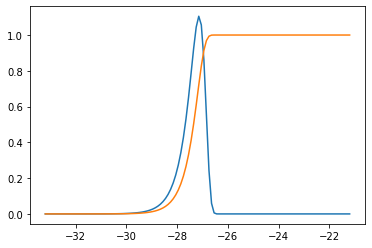

logf:  -26.88160320512492
1 50 1.3133993435141092e-27
new scale  2 0.15848931924611134
done generating events


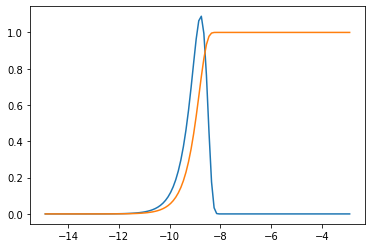

logf:  -8.50958933906388
2 50 3.093218941466548e-09
new scale  3 0.630957344480193
done generating events


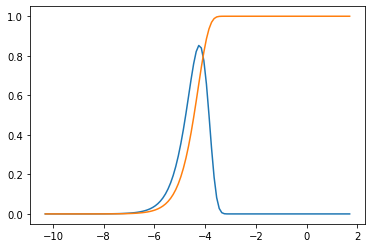

logf:  -3.803718059209566
3 50 0.000157138260332868
new scale  4 2.5118864315095797
done generating events


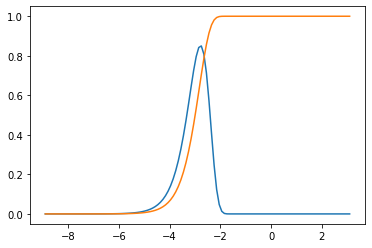

logf:  -2.360716097852375
4 50 0.004357966647280502
new scale  5 10.0
done generating events


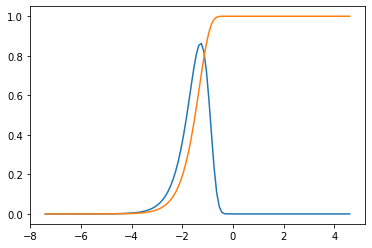

logf:  -0.8720933952264159
5 50 0.13424762299675308
new scale  0 0.01
/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: IntegrationWarning: The integral is probably divergent, or slowly convergent.

done generating events


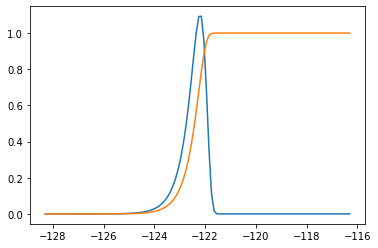

logf:  -121.94876505196474
0 100 1.1252135361842491e-122
new scale  1 0.039810717055349734
/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: IntegrationWarning: The integral is probably divergent, or slowly convergent.

done generating events


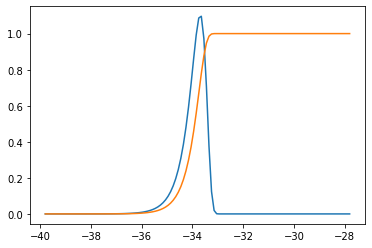

logf:  -33.44074240683083
1 100 3.6245791940744286e-34
new scale  2 0.15848931924611134
/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: IntegrationWarning: The integral is probably divergent, or slowly convergent.

done generating events


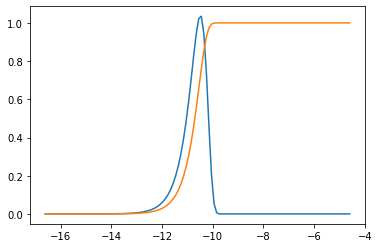

logf:  -10.198615641620234
2 100 6.329717949129098e-11
new scale  3 0.630957344480193
done generating events


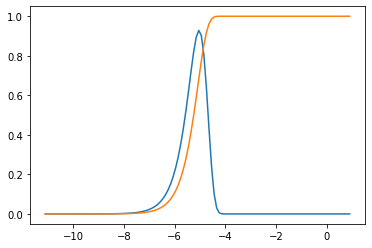

logf:  -4.673379702318624
3 100 2.12138892721439e-05
new scale  4 2.5118864315095797
done generating events


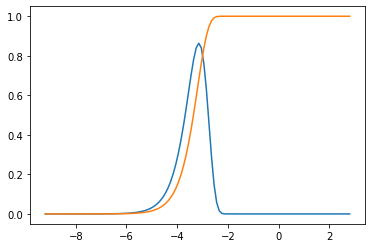

logf:  -2.740589655019792
4 100 0.0018172318710904165
new scale  5 10.0
done generating events


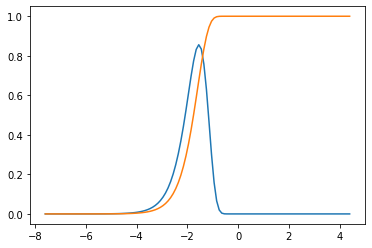

logf:  -1.1283982364673129
5 100 0.07440493875352854


In [65]:
N = np.array([5, 10, 20, 30, 50, 100])

Q = np.logspace(-2, 1, num = 6)
#fexp = np.linspace(-10, -4, num = 6)

#f = np.zeros([6,6])

i = 0
j = 0

for n in N:
    j = 0
    for q in Q:
        qa = np.array([q,q])
        print('new scale ', j, q)
        #print('fexp: ', fexp[i])
        logf = max_f(1.0, n, qa, rho_mirrordisk, logfexp = 0, data = data) #use the new function
        print('logf: ', logf)
        f[i, j] = np.power(10, logf)
        print(j, n, f[i,j])
        j = j+1
    i = i+1
    
np.savetxt('rescaled_los_MD_nomask.txt', f)

(1e-100, 1)

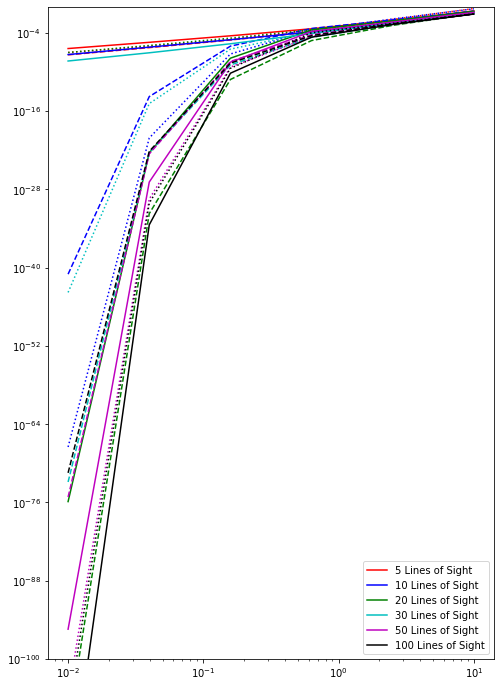

In [68]:
plt.figure(figsize =  [8,12])

N = np.array([5, 10, 20, 30, 50, 100])
cols = np.array(['r', 'b', 'g', 'c', 'm', 'k'])

f = np.loadtxt('rescaled_los_MD_nomask.txt')

fm = np.loadtxt('rescaled_los_MD_masked.txt')
fm5 = np.loadtxt('rescaled_los_MD_masked5.txt')


for j in np.arange(6):
    lab = '%i Lines of Sight'%N[j]
    plt.loglog(Q, f[j,:], c = cols[j], ls = '-', label = lab)
    plt.loglog(Q, fm[j,:], c = cols[j], ls = '--')
    plt.loglog(Q, fm5[j,:],  c = cols[j], ls = ':')
    
plt.legend()
plt.ylim(1e-100, 1)

In [23]:
#calculate constraints on mirror disk, rescaled from our own, starting at 1:1 mirror baryon equality

Qr = np.logspace(-0.5,1.5,num = 9)
Qz = np.logspace(-1,1,num = 9)
#Q = np.meshgrid(Qr, Qr)
result_array_md_20 = np.array([])


for qr in Qr:
    for qz in Qz:
        q = np.array([qr,qz])
        n_20 = N_looped(1.0,1.0,20, q, rho_mirrordisk)
        #n_cor = N(1.0,8.5,1.0,0.0,0.0,q, rho_mirrordisk, True)
        #n_lmc = N(1.0,50,1.0,280,-32,q, rho_mirrordisk, True)
        result = (q[0], q[1], n_20)
        result_array_md_20 = np.append(result_array_md_20, result)
        print(q, result)
        print('newline')
    
np.savetxt('results_array_darkdisk_20.txt', result_array_md_20)


done for another source. 161.27218657186486 161.27218657186486
done for another source. 109.85717432059921 137.98064522130795
done for another source. 2956.791361986162 1710.8177844944369
done for another source. 109.91075520015767 1482.630504317919
done for another source. 114.63692298082155 1327.0956614687984
done for another source. 1086.1249015800554 1290.0634206166521
done for another source. 352.4651625574939 1201.773300828851
done for another source. 192.76538091250637 1126.2200028288128
done for another source. 245.5102938249244 1064.9594286767635
done for another source. 142.65736710562436 1011.3158946114391
done for another source. 181.25424755367257 965.7993151785822
done for another source. 190.7917201552349 926.3212622012497
done for another source. 152.6814652335008 890.9875506122944
done for another source. 128.98320270836047 859.2688447611456
done for another source. 1201.364463119405 886.1932761095376
done for another source. 117.06224617727018 858.5518843089214
done f

In [14]:
np.savetxt('results_array_darkdisk_20.txt', result_array_md_20)

TypeError: Mismatch between array dtype ('object') and format specifier ('%.18e')

[[ 0.31622777  0.56234133  1.          1.77827941  3.16227766  5.62341325
  10.         17.7827941  31.6227766 ]
 [ 0.31622777  0.56234133  1.          1.77827941  3.16227766  5.62341325
  10.         17.7827941  31.6227766 ]
 [ 0.31622777  0.56234133  1.          1.77827941  3.16227766  5.62341325
  10.         17.7827941  31.6227766 ]
 [ 0.31622777  0.56234133  1.          1.77827941  3.16227766  5.62341325
  10.         17.7827941  31.6227766 ]
 [ 0.31622777  0.56234133  1.          1.77827941  3.16227766  5.62341325
  10.         17.7827941  31.6227766 ]
 [ 0.31622777  0.56234133  1.          1.77827941  3.16227766  5.62341325
  10.         17.7827941  31.6227766 ]
 [ 0.31622777  0.56234133  1.          1.77827941  3.16227766  5.62341325
  10.         17.7827941  31.6227766 ]
 [ 0.31622777  0.56234133  1.          1.77827941  3.16227766  5.62341325
  10.         17.7827941  31.6227766 ]
 [ 0.31622777  0.56234133  1.          1.77827941  3.16227766  5.62341325
  10.         17.78279

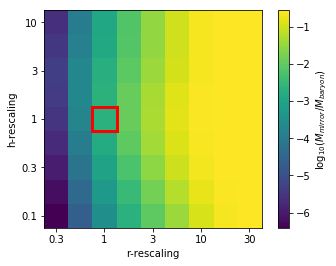

In [51]:
import matplotlib.patches as patches

qrlist = result_array_md_20[0::3]
qzlist = result_array_md_20[1::3]
f_mdm = 1/result_array_md_20[2::3]

s = 9

fmatrix = np.ones([s,s])
qr_matrix = np.ones([s,s])
qz_matrix = np.ones([s,s])

n = 0
for j in np.arange(s):
    for i in np.flip(np.arange(s)):
        qr_matrix[i,j] = qrlist[n]
        qz_matrix[i,j] = qzlist[n]
        
        fmatrix[i,j] = f_mdm[n]
        n = n+1
        
print(qr_matrix)
print(qz_matrix)
print(fmatrix)

fig,ax = plt.subplots(1)

im = ax.imshow(np.log10(fmatrix))

ax.set_ylabel('h-rescaling')
ax.set_xlabel('r-rescaling')

plt.yticks([0,2,4,6,8], ['10', '3','1', '0.3','0.1'])
plt.xticks([0,2,4,6,8], ['0.3','1','3', '10', '30'])


rect = patches.Rectangle((1.5,3.5),1,1,linewidth=3,edgecolor='r',facecolor='none')

ax.add_patch(rect)

c = fig.colorbar(im)
c.set_label('$\log_{10}(M_{mirror}/M_{baryon})$')

plt.savefig('rescaled_disk_colorplot_n20_99.pdf')

Calculate for squashed semi-isothermal DM halo

In [10]:
#calculate constraints for different sphericalities
#do for core source, LMC source, and 20 sources
Q = np.linspace(0.01,1,num = 20)
result_array_5 = np.array([])


for q in Q:
    n_5 = N_looped(1.0,1.0,5,q)
    #n_cor = N(1.0,8.5,1.0,0.0,0.0,q, True)
    #n_lmc = N(1.0,50,1.0,280,-32,q, True)
    result = (q,n_5)
    result_array_5 = np.append(result_array_5, result)
    print(q,n_5)
    
#np.savetxt('results_array_sphericality_20.txt', result_array_q)


done for another source
done for another source
done for another source
done for another source
done for another source
0.01 1443.5342087475753
done for another source
done for another source
done for another source
done for another source
done for another source
0.06210526315789474 4887.705520145685
done for another source
done for another source
done for another source
done for another source
done for another source
0.11421052631578947 6678.845403469813
done for another source
done for another source
done for another source
done for another source
done for another source
0.16631578947368422 7752.78841317631
done for another source
done for another source
done for another source
done for another source
done for another source
0.21842105263157896 8413.819799983972
done for another source
done for another source
done for another source
done for another source
done for another source
0.2705263157894737 8811.941148505093
done for another source
done for another source
done for another sou

In [ ]:
result_array_5 = result_array

In [35]:
#really good sphericality run, with 20 steps, and 100 sources. RUN OVERNIGHT, should take ~5 hours

Q = np.linspace(0.01,1,num = 20)
result_array_q100 = np.array([])

for q in Q:
    n_100 = N_looped(1.0,1.0,100,q)
    print('done the big one')
    n_20 = N_looped(1.0,1.0,20,q)
    n_cor = N(1.0,8.5,1.0,0.0,0.0,q, True)
    n_lmc = N(1.0,50,1.0,280,-32,q, True)
    result = (q,n_100, n_20, n_cor, n_lmc)
    result_array_q100 = np.append(result_array_q100, result)
    print(q,n_100, n_20, n_cor, n_lmc)

np.savetxt('results_array_sphericality_100.txt', result_array_q100)

    

done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another source
done for another

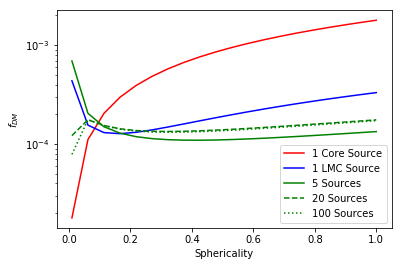

In [57]:
result_array_q = np.loadtxt('results_array_sphericality_100.txt')

q = result_array_q[0::5]
f_5 = 1/(result_array_5[1::2]*logsense(1.0,1e-2,0.5))
f_20 = 1/(result_array_q[1::5]*logsense(1.0,1e-2,0.5))
f_100 = 1/(result_array_q[2::5]*logsense(1.0,1e-2,0.5))
f_cor = 1/(result_array_q[3::5]*logsense(1.0,1e-2,0.5))
f_lmc = 1/(result_array_q[4::5]*logsense(1.0,1e-2,0.5))

plt.plot(q,f_cor, 'r', label = '1 Core Source')
plt.plot(q,f_lmc, 'b', label = '1 LMC Source')
plt.plot(q,f_5, 'g-', label = '5 Sources')
plt.plot(q,f_20, 'g--', label = '20 Sources')
plt.plot(q,f_100, 'g:', label = '100 Sources')

plt.yscale('log')
plt.legend()

plt.xlabel('Sphericality')
plt.ylabel('$f_{DM}$')

plt.savefig('fdm_variable_baryonic_microlensing_sphericality.svg')

done generating events


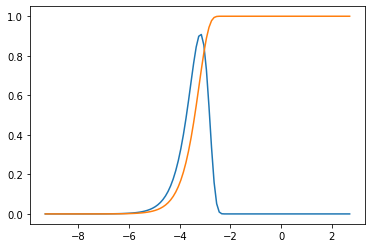

done generating events


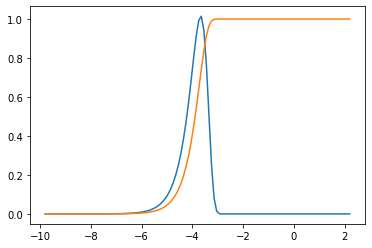

done generating events


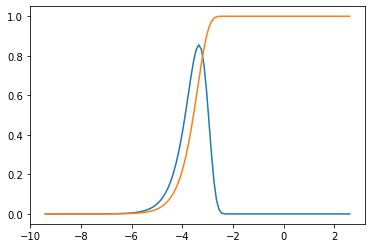

[-2.82766793 -3.37634254 -2.92869616]
done  3
done generating events


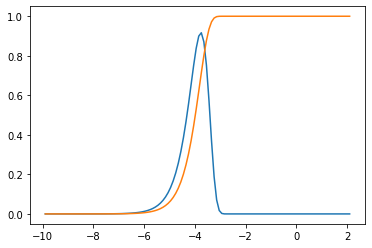

done generating events


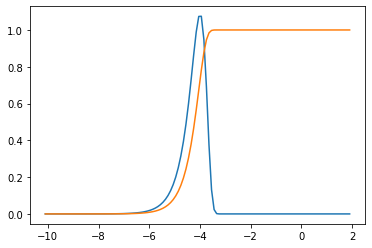

done generating events


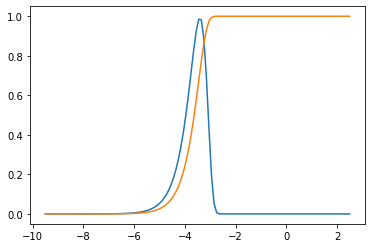

[-3.40464164 -3.73737307 -3.10396501]
done  5
done generating events


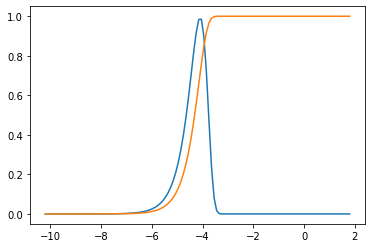

done generating events


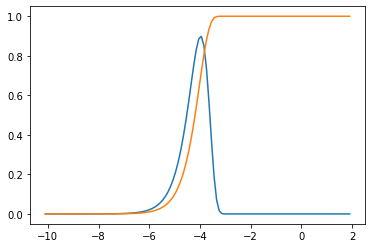

done generating events


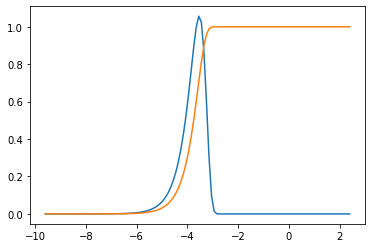

[-3.78077882 -3.60601941 -3.25970078]
done  10
done generating events


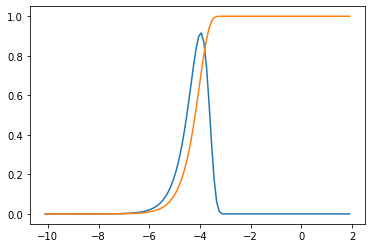

done generating events


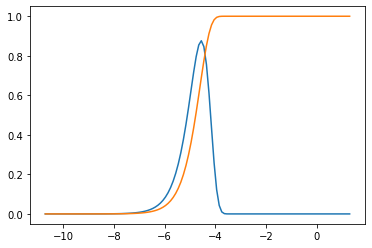

done generating events


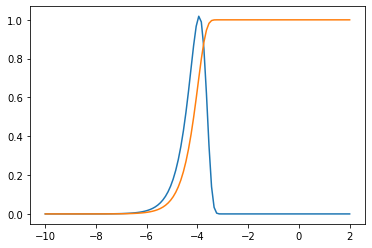

[-3.61426274 -4.15953657 -3.63708155]
done  20
done generating events


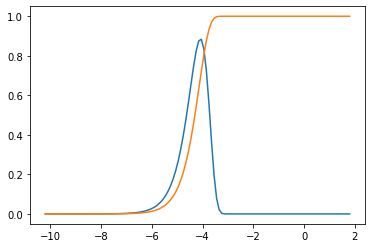

done generating events


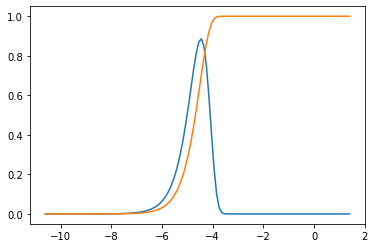

done generating events


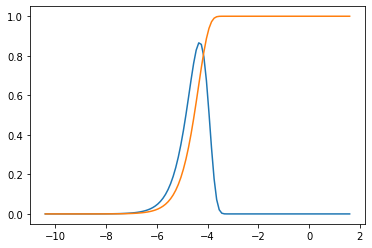

[-3.70060283 -4.07826979 -3.91235265]
done  50
done generating events


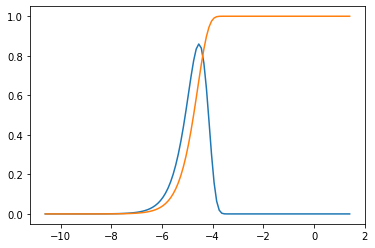

done generating events


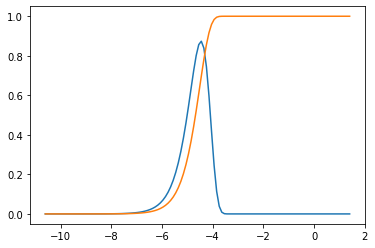

done generating events


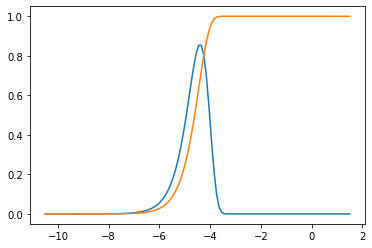

[-4.12979185 -4.06652271 -3.98500289]
done  100


AttributeError: module 'matplotlib.pyplot' has no attribute 'savetxt'

In [12]:
nrange = [3,5,10,20,50,100]
fm = np.float64(np.zeros([3,6]))

i = 0
for n in nrange:
    fm[0,i] = max_f(1.0, n, 1.0, rho_NFW, logfexp = 0, data = data) #use the new function
    fm[1,i] = max_f(1.0, n, 1.0, rho_NFW, logfexp = 0, data = data_masked) #use the new function
    fm[2,i] = max_f(1.0, n, 1.0, rho_NFW, logfexp = 0, data = data_masked5) #use the new function
    print(fm[:,i])
    print('done ', n)
    
    i = i+1
    
plt.savetxt('los_newmeth_masked.txt', fm)

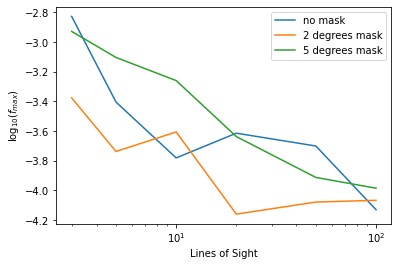

In [15]:
plt.semilogx(nrange, fm[0,:], label = 'no mask')
plt.semilogx(nrange, fm[1,:], label = '2 degrees mask')
plt.semilogx(nrange, fm[2,:], label = '5 degrees mask')

plt.legend()
plt.xlabel('Lines of Sight')
plt.ylabel('$\log_{10}(f_{max})$')
plt.savefig('newlims_los_masks.png')

In [7]:
#calculate microlensing constraints for 1 solar mass, with variable number of LSST sightlines
#still need to run overnight

nrange = [3,5,10,20,50,100]
result_array_los_masked = np.array([])
cutoff = 1
nstars = 1.0e9
for n in nrange:
    start = time.time()
    Num = N_looped(1.0,cutoff,n,1.0,rho_NFW,True,iso = True, error = 0.05, data = data_masked5)
    result = (n,Num)
    #plt.scatter(m,n, c = 'g')
    result_array_los_masked = np.append(result_array_los_masked, result)
    end = time.time()
    tim = end - start
    print(n,Num,tim)
    
np.savetxt('result_array_los_masked5.txt', result_array_los_masked)

done for another source. 2618.0015011292767 2618.0015011292767
done for another source. 297.7116327494039 1863.137686295549
3 1521.2455506579097 12.368542194366455
done for another source. 2618.0015011292767 2618.0015011292767
done for another source. 1984.866067200416 2323.104083402075
done for another source. 949.4077636964018 1974.419768472567
done for another source. 204.78154987431995 1712.960576719056
done for another source. 2196.299306658237 1819.926723470051
5 1819.926723470051 30.81463313102722
done for another source. 2618.0015011292767 2618.0015011292767
done for another source. 1311.0257180340166 2070.352662381672
done for another source. 1326.3495791614382 1855.7948431335724
done for another source. 61.71482065623171 1607.461680607979
done for another source. 596.8768969588477 1462.326519530801
done for another source. 2779.7282227363667 1752.0884319811225
done for another source. 5849.9472881888005 2742.2818057616573
done for another source. 412.52312999625724 2569.31269

In [8]:
#np.savetxt('result_array_los_nomask.txt', result_array_los)
f_cor = 1/(N(1.0,8.5,1.0,0.0,0.0,1.0, rho_NFW, True, error = 0.05)*logsense(1.0,1e-2,0.5))
f_lmc = 1/(N(1.0,50,1.0,280,-32,1.0, rho_NFW, True, error = 0.05)*logsense(1.0,1e-2,0.5))


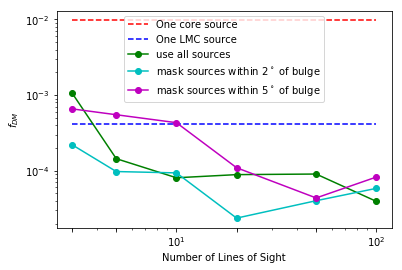

In [10]:
result_array_los = np.loadtxt('result_array_los_nomask.txt')
result_array_los_masked = np.loadtxt('result_array_los_masked.txt')
result_array_los_masked5 = np.loadtxt('result_array_los_masked5.txt')

n = result_array_los[0::2]
f = 1/(result_array_los[1::2]*logsense(1.0,1e-2,0.5))

fm = 1/(result_array_los_masked[1::2]*logsense(1.0,1e-2,0.5))
fm5 = 1/(result_array_los_masked5[1::2]*logsense(1.0,1e-2,0.5))

plt.plot([3,100], [f_cor,f_cor], 'r--', label = 'One core source')
plt.plot([3,100], [f_lmc,f_lmc], 'b--', label = 'One LMC source')
#plt.plot([3,100], [f[-1],f[-1]], 'g:')
plt.plot(n,f, 'go-', label = 'use all sources')
plt.plot(n,fm, 'co-', label = 'mask sources within $2^\circ$ of bulge')
plt.plot(n,fm5, 'mo-', label = 'mask sources within $5^\circ$ of bulge')

plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.xticks([3,5,10,20,50,100])
plt.yticks(np.logspace(-4,-2,3))
plt.xlabel('Number of Lines of Sight')
plt.ylabel('$f_{DM}$')

plt.savefig('fdm_los.pdf')

In [63]:
#compute mass-dependant constraints for 20 lines of sight

M = np.logspace(-4, 7, num = 25)
result_array_20los = np.array([])
cutoff = 1
nstars = 1.0e9
for m in M:
    start = time.time()
    n_20 = N_looped(m,cutoff,20,1.0, rho_NFW)
    result = (m,n_20)
    #plt.scatter(m,n, c = 'g')
    result_array_20los = np.append(result_array_20los, result)
    end = time.time()
    tim = end - start
    print(m,n_20,tim)

np.savetxt('basic_constraints_20los_newvel.txt', result_array_20los)


0.90060824
done for another source. 3962.7718828647407 3962.7718828647407
5.8703566
done for another source. 381204.1567542078 269566.60836209136
9.22331
done for another source. 850608.7241454978 538165.8710472431
8.533962
done for another source. 563538.2011305144 544619.7798495593
4.3311443
done for another source. 147602.56366134397 491574.8844709076
12.75977
done for another source. 739823.0942612485 540920.133663498
8.022905
done for another source. 41245.171806236205 501037.3111587806
17.891254
done for another source. 108907.9809799436 470256.53351836494
12.473443
done for another source. 638271.6169707588 491767.82186133094
5.7884297
done for another source. 315401.98270796984 477074.2841801744
6.399199
done for another source. 132097.99926061003 456612.88633798034
6.8757834
done for another source. 530945.9899775689 463263.08687596506
7.272426
done for another source. 449524.7877655461 462220.7919596796
7.6453586
done for another source. 398203.9060512485 457945.0323808607
8.

Mass-dependant constraints for core and LMC, with and without baryons

In [31]:
#generate data for core vs lmc, baryons and no

M = np.logspace(-4, 7, num = 25)
result_array_bar = np.array([])
cutoff = 1
nstars = 1.0e9
for m in M:
    start = time.time()
    n_cor = N(m,8.5,1.0,0.0,0.0,1.0, True)
    n_lmc = N(m,50,1.0,280,-32,1.0, True)
    result = (m,n_cor, n_lmc)
    #plt.scatter(m,n, c = 'g')
    result_array_bar = np.append(result_array_bar, result)
    end = time.time()
    tim = end - start
    print(m,n_cor, n_lmc,tim)

np.savetxt('basic_constraints_bar.txt', result_array_bar)


0.0001 204778.38487326188 340963.97119239345 15.828810930252075
0.0002872984833353666 398171.4500092309 660479.1470564423 14.697474956512451
0.0008254041852680181 414573.7383390792 680315.1035435317 13.883987188339233
0.0023713737056616554 181645.2714647061 295050.8666038173 14.26973009109497
0.006812920690579608 57018.27322485963 93369.06065514404 14.954045534133911
0.019573417814876596 15175.589686182677 26010.183375530454 14.473320960998535
0.05623413251903491 4063.248918810835 8151.528750249396 13.829520225524902
0.1615598098439873 1152.6732496213046 3601.065863439158 13.015076398849487
0.46415888336127775 579.7411299210269 2839.570036350131 12.318207502365112
1.333521432163324 576.2573964477152 3158.626831992545 11.650141954421997
3.831186849557285 700.4854113918273 3929.46981982227 11.234078407287598
11.00694171252208 901.8831448375665 5049.739363787893 11.269829511642456
31.622776601683793 1190.5859040606508 6405.784436710588 11.331705331802368
90.85175756516861 1600.41646178822

In [32]:
result_array_nobar = np.array([])
cutoff = 1
nstars = 1.0e9
for m in M:
    start = time.time()
    n_cor = N(m,8.5,1.0,0.0,0.0,1.0, False)
    n_lmc = N(m,50,1.0,280,-32,1.0, False)
    result = (m,n_cor, n_lmc)
    #plt.scatter(m,n, c = 'g')
    result_array_nobar = np.append(result_array_nobar, result)
    end = time.time()
    tim = end - start
    print(m,n_cor, n_lmc,tim)

np.savetxt('basic_constraints_nobar.txt', result_array_nobar)


0.0001 3217889.39488471 1256904.2536829947 6.210905313491821
0.0002872984833353666 6469746.273300671 2518593.8749863193 5.930089473724365
0.0008254041852680181 7728519.7849703 2983866.858930156 5.582812070846558
0.0023713737056616554 5155392.335177498 1976832.2140623042 6.6982715129852295
0.006812920690579608 3053116.19263805 1170006.96365273 7.577120542526245
0.019573417814876596 1802658.9027543212 690803.0385322875 7.860013484954834
0.05623413251903491 1064780.1756287403 408042.617326721 7.252586126327515
0.1615598098439873 629450.7438548256 241221.25731703063 7.383206605911255
0.46415888336127775 372617.9203928172 142801.07922345487 7.764142036437988
1.333521432163324 221093.90139456026 84735.99217649293 7.520487546920776
3.831186849557285 131699.9555650767 50479.59756058974 7.489810943603516
11.00694171252208 78962.06345363145 30270.06980749116 7.098506450653076
31.622776601683793 47851.692227699976 18348.369143094922 7.154775619506836
90.85175756516861 29503.0294950396 11317.05427

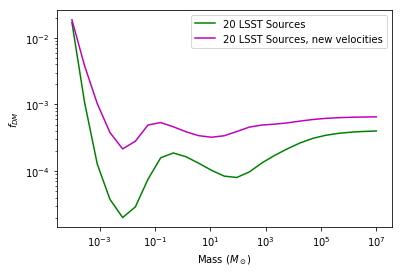

In [68]:
#plot constraints for core and lmc
result_array = np.loadtxt('basic_constraints_bar.txt')
m = result_array[0::3]
f_cor = 1.0/result_array[1::3]
f_lmc = 1.0/result_array[2::3]

result_array = np.loadtxt('basic_constraints_nobar.txt')
m = result_array[0::3]
fn_cor = 1.0/result_array[1::3]
fn_lmc = 1.0/result_array[2::3]

result_array = np.loadtxt('basic_constraints_20los.txt')
m = result_array[0::2]
f_20 = 1.0/result_array[1::2]

result_array = np.loadtxt('basic_constraints_20los_newvel.txt')
m = result_array[0::2]
f_20nv = 1.0/result_array[1::2]


#plt.loglog(m,f_cor/logsense(m,1e-2,0.5), c = 'r', label = "Sources in core")#, label = 'More Massive Halo')
#plt.loglog(m,fn_cor/logsense(m,1e-2,0.5), 'r--')#, label = 'More Massive Halo')

#plt.loglog(m,f_lmc/logsense(m,1e-2,0.5), c = 'b', label = "Sources in LMC")#, label = 'More Massive Halo')
#plt.loglog(m,fn_lmc/logsense(m,1e-2,0.5), 'b--')#, label = 'More Massive Halo')

plt.loglog(m,f_20/logsense(m,1e-2,0.5), c = 'g', label = "20 LSST Sources")#, label = 'More Massive Halo')

plt.loglog(m,f_20nv/logsense(m,1e-2,0.5), c = 'm', label = "20 LSST Sources, new velocities")#, label = 'More Massive Halo')

#plt.loglog([],[], 'k', label = "With baryons")
#plt.loglog([],[], 'k--', label = "Without baryons")

plt.legend()
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('$f_{DM}$')

plt.savefig('new_velocity_20los.svg')

In [2]:
r = np.linspace(-10000, 10000, 100)*u.parsec
z = np.linspace(-10000, 10000, 100)*u.parsec

co = np.meshgrid(r,z)
rs = rho_semis(co[0],co[1], 1.0)

plt.imshow(rs.value)
plt.colorbar()
plt.show()

rm = rho_mirrordisktilt(np.abs(co[0]),co[1], [0.0, 0.0])
plt.imshow(rm.value)
plt.colorbar()


NameError: name 'rho_semis' is not defined

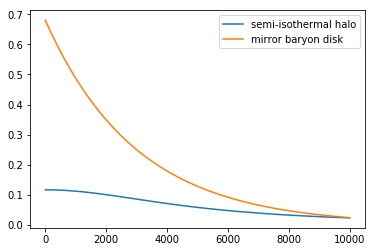

In [32]:
r = np.linspace(0,10000)*u.parsec
z = 0*u.parsec
rs = rho_semis(r, z, 1.0)
rm = rho_mirrordisk(r,z,[1.0,1.0])

plt.plot(r,rs.value, label ='semi-isothermal halo')
plt.plot(r,rm.value, label ='mirror baryon disk')

plt.legend()